In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import warnings

# Ignore a bunch of Arviz/pymc3 deprecated warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_FOLDER = '../../data'
TULIPS_DATA = 'tulips.csv'

### Code 8.19

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{TULIPS_DATA}')
df.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [4]:
df[['water', 'shade', 'blooms']].describe()

,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


## Model 1

$$
\begin{align*}
~ B_i & \sim N(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta_W (W_i - \bar{W}) + \beta_S (S_i - \bar{S}) 
\end{align*}
$$

### Code 8.20

In [5]:
df['blooms_std'] = df['blooms'] / df['blooms'].max()
df['water_cent'] = df['water'] - df['water'].mean()
df['shade_cent'] = df['shade'] - df['shade'].mean()

At this point, $B_i \in [0, 1]$ and both $W_i - \bar{W}$ and $S_i - \bar{S}$ take on values in $\{-1, 0, 1\}$. The prior for $\alpha$ places $95\%$ of the probability mass in the interval $[0, 1]$.
$$
    \alpha \sim N(0.5, 0.25). 
$$
The priors for $\beta_W$ and $\beta_S$ are set to $N(0, 0.25)$ so that $95\%$ of the mass is on slopes in the interval $[-0.5, 0.5]$. 

In [6]:
with pm.Model() as m_8_4:
    a = pm.Normal('a', mu=0.5, sigma=0.25)
    bw = pm.Normal('bw', mu=0, sigma=0.25)
    bs = pm.Normal('bs', mu=0, sigma=0.25)
    
    mu = pm.Deterministic('mu', a + bw * df['water_cent'] + bs * df['shade_cent'])
    sigma = pm.Exponential('sigma', lam=1)
    
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    
    trace_8_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [7]:
az.summary(trace_8_4, var_names=['a', 'bw', 'bs', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.359,0.034,0.304,0.412,0.000,0.0,5188.0,2976.0,1.0
bw,0.205,0.041,0.134,0.264,0.001,0.0,4591.0,2951.0,1.0
bs,-0.112,0.041,-0.177,-0.045,0.001,0.0,5494.0,3409.0,1.0
sigma,0.175,0.027,0.134,0.217,0.000,0.0,3333.0,2693.0,1.0


## Model 2 (Simple Interaction)

$$
\begin{align*}
~ B_i      & \sim N(\mu_i, \sigma) \\
\mu_i      & = \alpha + \beta_W (W_i - \bar{W}) + \beta_S (S_i - \bar{S}) 
                      + \beta_{WS} (W_i - \bar{W}) (S_i - \bar{S}) \\
\alpha     & \sim N(0.5, 0.25) \\
\beta_W    & \sim N(0, 0.25) \\
\beta_S    & \sim N(0, 0.25) \\
\beta_{WS} & \sim N(0, 0.25) 
\end{align*}
$$

### Code 8.24

In [8]:
with pm.Model() as m_8_5:
    a = pm.Normal('a', mu=0.5, sigma=0.25)
    bw = pm.Normal('bw', mu=0, sigma=0.25)
    bs = pm.Normal('bs', mu=0, sigma=0.25)
    bws = pm.Normal('bws', mu=0, sigma=0.25)
    
    mu = pm.Deterministic('mu', a + bw * df['water_cent'] + bs * df['shade_cent'] + 
                          bws * df['water_cent'] * df['shade_cent'])
    sigma = pm.Exponential('sigma', lam=1)
    
    blooms_std = pm.Normal('blooms_std', mu=mu, sigma=sigma, observed=df['blooms_std'])
    
    trace_8_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bws, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [9]:
az.summary(trace_8_5, var_names=['a', 'bw', 'bs', 'bws', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.358,0.028,0.314,0.404,0.000,0.0,4149.0,3030.0,1.0
bw,0.205,0.034,0.152,0.259,0.000,0.0,5497.0,3198.0,1.0
bs,-0.113,0.033,-0.163,-0.059,0.000,0.0,4569.0,3182.0,1.0
bws,-0.142,0.041,-0.208,-0.078,0.001,0.0,4404.0,3029.0,1.0
sigma,0.143,0.023,0.106,0.174,0.000,0.0,3843.0,2680.0,1.0


## Triptych Plots

Modified from https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_08.ipynb

In [10]:
N_SAMPLES = 20

with m_8_4:
    m_8_4_post = pm.sample_posterior_predictive(trace_8_4, samples=N_SAMPLES, var_names=['a','bw', 'bs'])

with m_8_5:
    m_8_5_post = pm.sample_posterior_predictive(trace_8_5, samples=N_SAMPLES, var_names=['a','bw', 'bs', 'bws'])

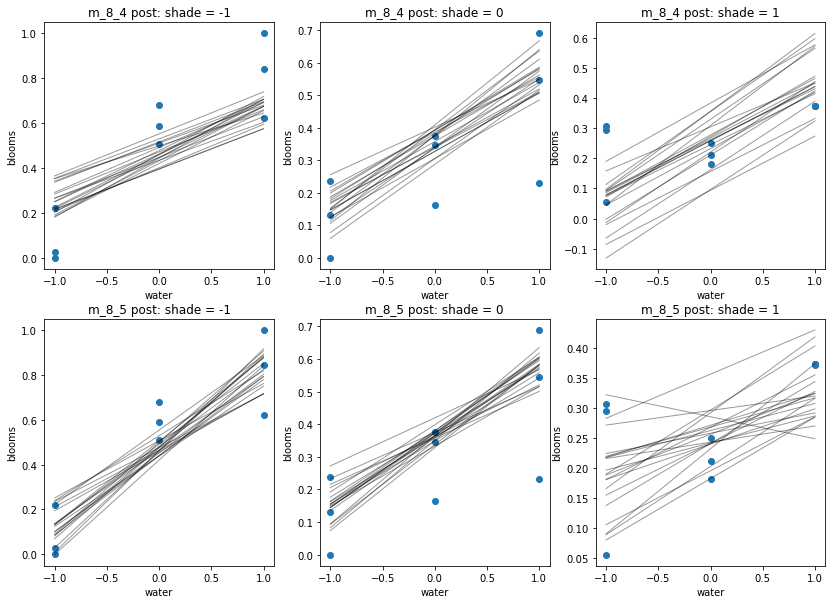

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(14,10))

pred_x = np.array([-1, 1])

for col, shade in enumerate([-1, 0, 1]):
    idx = (df['shade_cent'] == shade)
    
    # First do the scatter plots and the plot titles
    for row, ax in enumerate(axs[:, col]):
        ax.scatter(df.loc[idx, 'water_cent'], df.loc[idx, 'blooms_std'])
        
        ax.set_xlabel('water')
        ax.set_ylabel('blooms')
        
        model = 'm_8_4' if row == 0 else 'm_8_5'
        title = f'{model} post: shade = {shade}' 
        ax.set_title(title)
    
    # Plot model m_8_4
    ax = axs[0, col]
    pred_y = (
        m_8_4_post["a"]
        + m_8_4_post["bw"] * pred_x.reshape(-1, 1)
        + m_8_4_post["bs"]  * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    
    # Plot model 8_5
    ax = axs[1, col]
    pred_y = (
        m_8_5_post["a"]
        + m_8_5_post["bw"] * pred_x.reshape(-1, 1)
        + m_8_5_post["bs"] * shade
        + m_8_5_post["bws"] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))